In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [12]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [16]:
import seaborn as sns
sns.set_theme(style='darkgrid')  # or 'whitegrid', 'ticks', etc.


In [18]:
ticker = 'AAPL'
start_date = '2014-01-01'
end_date = '2024-12-31'

In [20]:
data = yf.download(ticker, start=start_date, end=end_date)
print("Data downloaded:")
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data downloaded:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2014-01-02  17.215370  17.336752  17.180823  17.294736  234684800
2014-01-03  16.837217  17.233108  16.820099  17.206965  392467600
2014-01-06  16.929029  17.018353  16.607523  16.727349  412610800
2014-01-07  16.807966  16.992217  16.741984  16.941175  317209200
2014-01-08  16.914404  16.979762  16.765945  16.769678  258529600


In [22]:
# Generate features:
# a) 10-day rolling average of the closing price
data['RollingAvg_10'] = data['Close'].rolling(window=10).mean()

# b) 10-day rolling standard deviation of the closing price
data['RollingStd_10'] = data['Close'].rolling(window=10).std()

# c) Daily returns (percentage change of closing price)
data['Return'] = data['Close'].pct_change()


In [24]:
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)


In [28]:
data = data.dropna()
print("\nData with new features:")
print(data[['Close', 'RollingAvg_10', 'RollingStd_10', 'Return', 'Target']].head())




Data with new features:
Price           Close RollingAvg_10 RollingStd_10    Return Target
Ticker           AAPL                                             
Date                                                              
2014-01-15  17.347023     16.901581      0.238898  0.020077      0
2014-01-16  17.250233     16.905068      0.244182 -0.005580      0
2014-01-17  16.827570     16.904103      0.244499 -0.024502      1
2014-01-21  17.089012     16.920101      0.251447  0.015537      1
2014-01-22  17.164948     16.955799      0.258985  0.004444      1


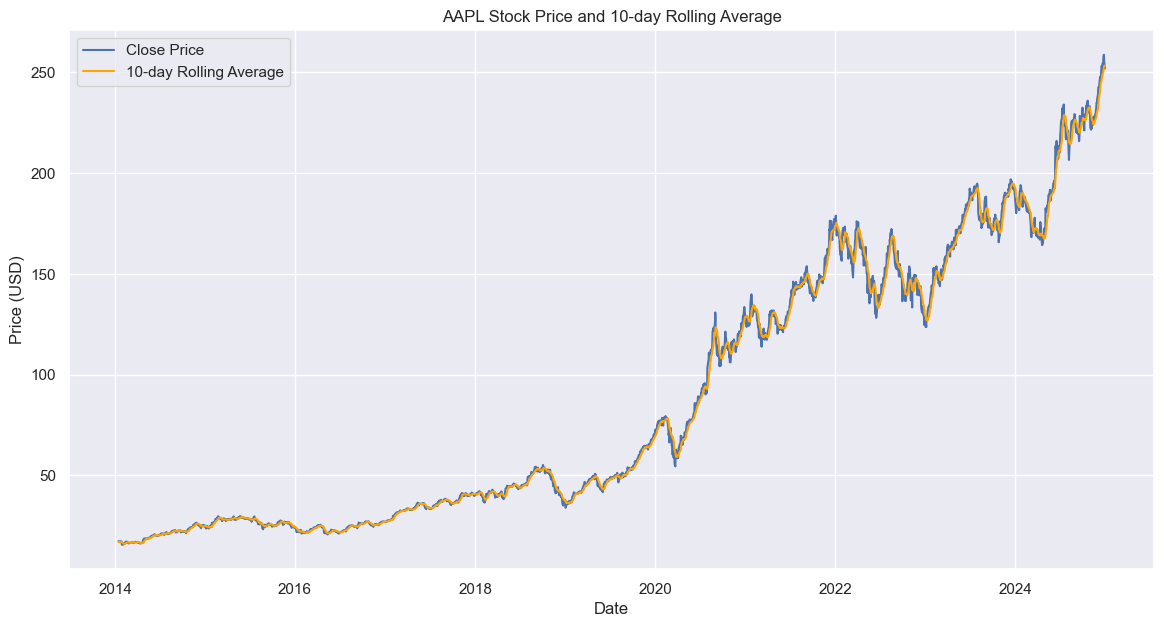

In [30]:
# Plot the closing price and its 10-day rolling average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['RollingAvg_10'], label='10-day Rolling Average', color='orange')
plt.title(f'{ticker} Stock Price and 10-day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


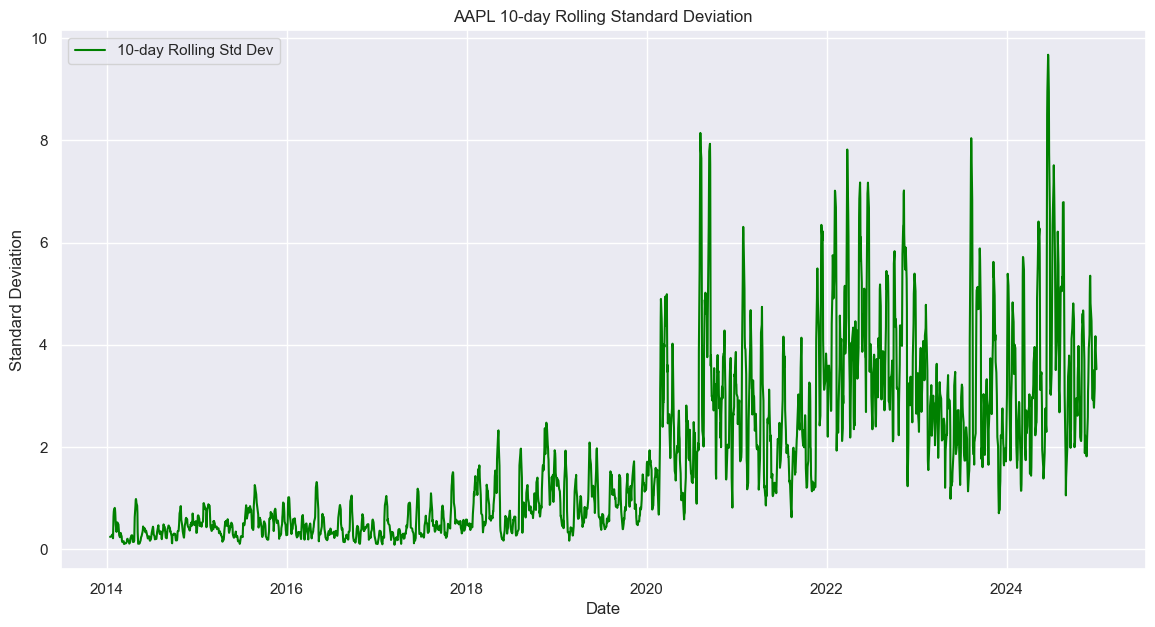

In [32]:
# Plot the 10-day rolling standard deviation
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['RollingStd_10'], label='10-day Rolling Std Dev', color='green')
plt.title(f'{ticker} 10-day Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

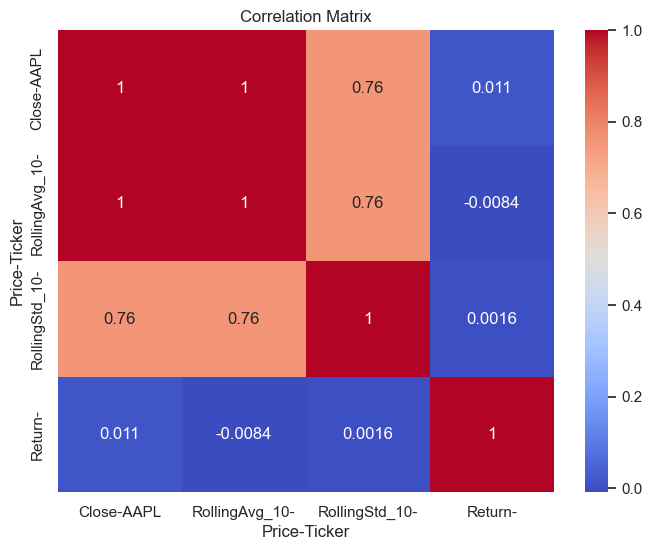

In [34]:
# Display a correlation matrix among selected features
plt.figure(figsize=(8, 6))
corr = data[['Close', 'RollingAvg_10', 'RollingStd_10', 'Return']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [36]:
# Select features and target variable
features = ['RollingAvg_10', 'RollingStd_10', 'Return']
X = data[features]
y = data['Target']

In [38]:
# Use a time-based train-test split: first 80% of the data for training, the last 20% for testing
split_index = int(0.8 * len(data))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [40]:
print("\nTrain and test set sizes:")
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)



Train and test set sizes:
Training set: (2206, 3) (2206,)
Testing set: (552, 3) (552,)


In [42]:
# a) Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print("\nLogistic Regression CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(lr_cv_scores.mean(), lr_cv_scores.std()))

# b) Extra Trees Classifier
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_cv_scores = cross_val_score(et, X_train, y_train, cv=5, scoring='accuracy')
print("Extra Trees Classifier CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(et_cv_scores.mean(), et_cv_scores.std()))



Logistic Regression CV Accuracy: Mean = 0.5245, Std = 0.0083
Extra Trees Classifier CV Accuracy: Mean = 0.4964, Std = 0.0187


In [44]:
et.fit(X_train, y_train)
y_pred = et.predict(X_test)


In [46]:
# Generate a classification report
print("\nClassification Report for Extra Trees Classifier on Test Set:")
print(classification_report(y_test, y_pred))



Classification Report for Extra Trees Classifier on Test Set:
              precision    recall  f1-score   support

           0       0.46      0.69      0.55       249
           1       0.56      0.32      0.40       303

    accuracy                           0.49       552
   macro avg       0.51      0.51      0.48       552
weighted avg       0.51      0.49      0.47       552



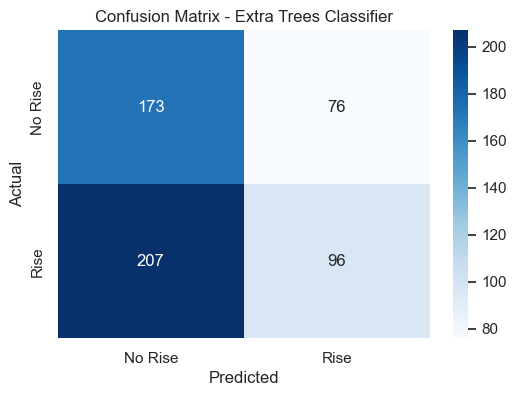

In [48]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['No Rise', 'Rise'], yticklabels=['No Rise', 'Rise'])
plt.title("Confusion Matrix - Extra Trees Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


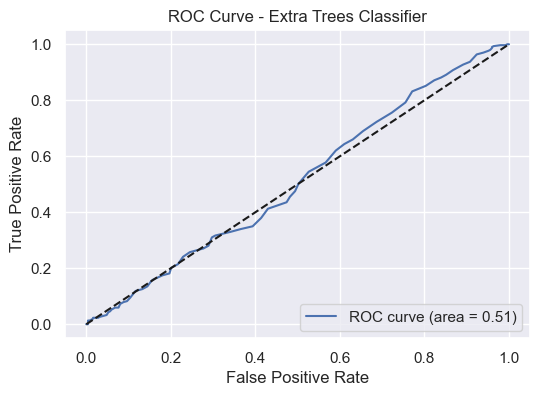

In [50]:
# Plot the ROC curve
y_pred_proba = et.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Extra Trees Classifier')
plt.legend(loc="lower right")
plt.show()

In [52]:
# Extract test period data
test_data = data.iloc[split_index:].copy()
test_data['Predicted'] = y_pred


In [60]:
# Strategy return: only earn the return when a rise is predicted
test_data['StrategyReturn'] = test_data['Return'] * test_data['Predicted']


In [62]:
# Calculate cumulative returns for both the market and the strategy
test_data['CumulativeMarketReturn'] = (1 + test_data['Return']).cumprod() - 1
test_data['CumulativeStrategyReturn'] = (1 + test_data['StrategyReturn']).cumprod() - 1


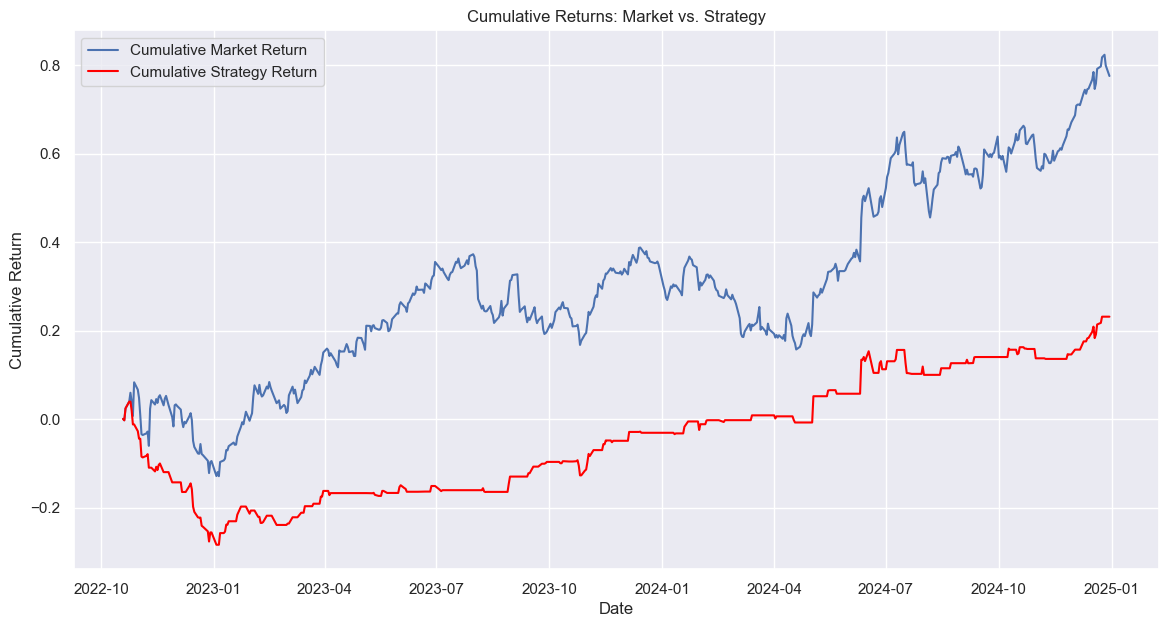

In [64]:
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['CumulativeMarketReturn'], label='Cumulative Market Return')
plt.plot(test_data.index, test_data['CumulativeStrategyReturn'], label='Cumulative Strategy Return', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns: Market vs. Strategy')
plt.legend()
plt.show()